<a href="https://colab.research.google.com/github/pvvq/ipynotebooks/blob/main/toy_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# toy graph


## Prerequisits

files, packages

In [1]:
%cd /content/drive/MyDrive/toy_dataloader

/content/drive/MyDrive/toy_dataloader


In [2]:
!ls

dataloader.py		mlp.png      test.csv	       toy_graph.gslides  train.csv
mlp_autoregressive.png	__pycache__  toy_equation.png  toy_graph.ipynb


In [3]:
!pip3 install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.8 MB/s eta 0:00:00


In [4]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GraphConv, GCNConv


from dataloader import ToyDataloader

## Prepare data

In [5]:
raw_data =np.loadtxt("train.csv", delimiter=',')

In [6]:
# raw_data[0][3:].reshape((5,100)).transpose((1, 0))
raw_data[0][:3]

array([14.15597908,  1.54983554,  0.29275331])

In [7]:
train_data = ToyDataloader("train.csv")
test_data = ToyDataloader("test.csv")

# train1 = next(iter(train_dataloader))
# print(train1['key'].shape)
# print(train1['initial_value'].shape)
# print(train1['output'].shape)
train_data[0]

{'key': array([14.155979 ,  1.5498356,  0.2927533], dtype=float32),
 'initial_value': array([1.        , 0.33333334, 0.        , 0.        , 0.        ],
       dtype=float32),
 'output': array([[7.18159437e-01, 7.60523826e-02, 2.32998267e-01, 2.40058228e-02,
         2.76884442e-04],
        [6.31400466e-01, 2.29315870e-02, 2.53465533e-01, 5.56746311e-02,
         1.26158248e-03],
        [5.85153937e-01, 7.73034943e-03, 2.39191964e-01, 8.35789815e-02,
         2.83205486e-03],
        [5.52648306e-01, 2.79346714e-03, 2.18574017e-01, 1.07119940e-01,
         4.84592235e-03],
        [5.26517808e-01, 1.06200785e-03, 1.98249474e-01, 1.26832798e-01,
         7.18905078e-03],
        [5.04188657e-01, 4.19229880e-04, 1.79789782e-01, 1.43351406e-01,
         9.77291632e-03],
        [4.84551817e-01, 1.75250520e-04, 1.63397744e-01, 1.57230541e-01,
         1.25297979e-02],
        [4.67000484e-01, 7.33547713e-05, 1.48928717e-01, 1.68922961e-01,
         1.54082906e-02],
        [4.51166302e-

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## MLP Baseline

In [ ]:
from torch.utils.data import DataLoader
from torch import nn

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_split = []
test_split = []
for i, data in enumerate(test_data):
  if i%2 == 0:
    val_split.append(data)
  else:
    test_split.append(data)
test_dataloader = DataLoader(test_split, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_split, batch_size=64, shuffle=True)

In [ ]:
next(iter(train_dataloader))['output'].shape

torch.Size([64, 99, 5])

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(8, 16*5),
      nn.Tanh(),
      nn.Linear(16*5, 64*5),
      nn.Tanh(),
      nn.Linear(64*5, 99*5)
    )

  def forward(self, x):
    return self.layers(x).reshape((-1,99,5))

In [ ]:
# @title MLP autoregressive
class MLPAutoregressive(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(8, 16),
      nn.Tanh(),
      nn.Linear(16, 16),
      nn.Tanh(),
      nn.Linear(16, 5)
    )

  def forward(self, x):
    key = x[:,:3]  # key
    x = x[:,3:]  # initial_value
    steps = []
    for i in range(99):
      # re-input result to predict next time step
      x = self.layers(torch.cat([key,x], dim=1))
      steps.append(x)

    output = torch.cat(steps, dim=1).reshape((-1,99,5))
    return output

In [ ]:
# @title MLP with time
class MLPTime(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(10, 16),
      nn.Tanh(),
      nn.Linear(16, 16),
      nn.Tanh(),
      nn.Linear(16, 5)
    )

  def forward(self, x, time):
    key = x[:,:3]  # key
    x = x[:,3:]  # initial_value
    input = torch.cat([key, time, x], dim=1)

    output = self.layers(input).reshape((-1,99,5))
    return output

In [ ]:
mlp = MLP()
mlp.to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

In [ ]:
def parse(data):
  key = data['key']
  init = data['initial_value']
  target = data['output']
  input = torch.cat([key, init], dim=1)
  return input.to(device), target.to(device)

In [ ]:
mlp.train()

epoch_losses = []
val_loss_min = np.Inf
val_patience = 5
val_count = 0

for epoch in range(100):
  train_loss = 0
  for data in train_dataloader:
    input, target = parse(data)

    optimizer.zero_grad()
    output = mlp(input)
    loss = loss_func(output, target)
    loss.backward()
    optimizer.step()

    train_loss += loss
  train_loss /= len(train_dataloader)
  print(f"\nepoch {epoch}:\ntrain loss: {train_loss}")

  # early stopping
  val_loss = 0
  for data in val_dataloader:
    input, target = parse(data)
    output = mlp(input)
    loss = loss_func(output, target)
    val_loss += loss
  val_loss /= len(val_dataloader)
  print(f"val loss: {val_loss}")

  epoch_losses.append([
      train_loss.detach().numpy(),
      val_loss.detach().numpy()
      ])

  if (val_loss < val_loss_min):
    val_count = 0
    val_loss_min = val_loss
  else:
    val_count += 1
    if (val_count > val_patience):
      print("!! early stopped")
      break


epoch 0:
train loss: 0.02097095176577568
val loss: 4.440616612555459e-05

epoch 1:
train loss: 4.245313539286144e-05
val loss: 3.815411764662713e-05

epoch 2:
train loss: 3.6848970921710134e-05
val loss: 3.336164081702009e-05

epoch 3:
train loss: 3.3119908039225265e-05
val loss: 3.0404768040170893e-05

epoch 4:
train loss: 3.071875107707456e-05
val loss: 2.892493830586318e-05

epoch 5:
train loss: 2.906675035774242e-05
val loss: 2.7455731469672173e-05

epoch 6:
train loss: 2.8191576348035596e-05
val loss: 2.65323633357184e-05

epoch 7:
train loss: 2.762453004834242e-05
val loss: 2.647070687089581e-05

epoch 8:
train loss: 2.7841393603011966e-05
val loss: 2.7869422410731204e-05

epoch 9:
train loss: 2.772050538624171e-05
val loss: 2.615645462356042e-05

epoch 10:
train loss: 2.8201229724800214e-05
val loss: 2.714180482144002e-05

epoch 11:
train loss: 2.7999623853247613e-05
val loss: 3.0485294701065868e-05

epoch 12:
train loss: 2.83987756120041e-05
val loss: 2.657895311131142e-05

ep

In [ ]:
import matplotlib.pyplot as plt

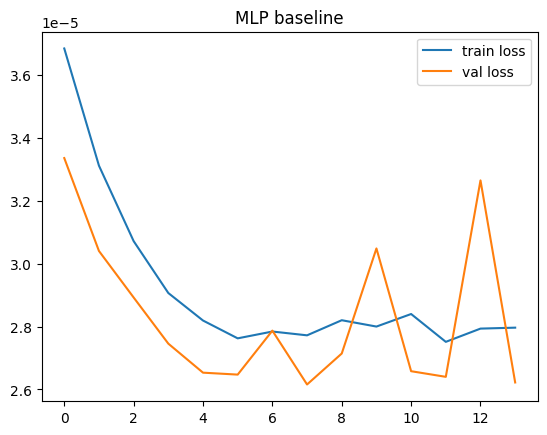

In [ ]:
losses = np.array(epoch_losses).transpose()
plt.plot(losses[0,2:], label="train loss")
plt.plot(losses[1,2:], label="val loss")
plt.legend()
plt.title("MLP baseline")
plt.savefig("mlp_autoregressive.png", dpi=300)
plt.show()

## Pytorch Geometric

### graph dataset/dataloader

In [9]:
from torch.utils.data import DataLoader
from torch import nn

In [10]:
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=False)
val_split = []
test_split = []
for i, data in enumerate(test_data):
  if i%2 == 0:
    val_split.append(data)
  else:
    test_split.append(data)
test_dataloader = DataLoader(test_split, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_split, batch_size=1, shuffle=True)

### graph neural network

In [11]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing, MulAggregation
from torch_geometric.utils import add_self_loops, degree


class GR(MessagePassing):
    """Graph Reaction Operator"""
    def __init__(self, edge_index, sign, k=0.):
        super().__init__(aggr=MulAggregation(), node_dim=0)  # multiply aggregation (Step 2).
        # rate constant => trainable parameter
        self.k = Parameter(torch.tensor([k]))
        self.sign = torch.tensor(sign)
        self.edge_index = edge_index

    def reset_parameters(self):
      self.k.data.zero_()

    def forward(self, x):
        # x has shape [N, 1]
        # edge_index has shape [2, E]

        # Step 1-2: Start propagating messages. call message() to constract msg first
        msg = self.propagate(self.edge_index, x=x)

        # Step 3: update rule:
        # kinetic rate law: delta = rate_constant * up/down * Mul(concentration)
        delta = self.k * self.sign * msg

        return delta

    def message(self, x_j):
        # x_j has shape [E, 1]

        # Step 1: Just send nodes' concentration as message
        return x_j

# {A:0, B:1, C:2, D:3, E:4}
ABC = ((0,2),(1,2),(0,1),(1,0),(0,0),(1,1))  # A + B -> C
ACD = ((0,3),(2,3),(0,2),(2,0),(0,0),(2,2))  # A + C -> D
ADE = ((0,4),(3,4),(0,3),(3,0),(0,0),(3,3))  # A + D -> E

class GNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.reaction1 = GR(torch.tensor(ABC).transpose(0,1), [-1,-1,1,0,0])#,14.155979)
    self.reaction2 = GR(torch.tensor(ACD).transpose(0,1), [-1,0,-1,1,0])#,1.5498356)
    self.reaction3 = GR(torch.tensor(ADE).transpose(0,1), [-1,0,0,-1,1])#,0.2927533)

  def reset_parameters(self):
    self.reaction1.reset_parameters()
    self.reaction2.reset_parameters()
    self.reaction3.reset_parameters()

  def forward(self, concentration):
    """forward one timestep on all reactions
    Args:
    concentration: concentration of all chemicals
    """
    for iter in range(5):
      delta1 = self.reaction1(concentration)
      delta2 = self.reaction2(concentration)
      delta3 = self.reaction3(concentration)
      concentration = concentration + delta1 + delta2 + delta3
    # print(concentration,delta1,delta2,delta3)
    return concentration

  def get_k(self):
    return torch.cat([
        self.reaction1.k.detach(),
        self.reaction2.k.detach(),
        self.reaction3.k.detach()
    ])

  def get_rate(self):
    with torch.no_grad():
      gradient = lambda input: torch.max(torch.abs(self.forward(input)-input))
      k1 = gradient(torch.tensor([1,1,0,0,0]))
      k2 = gradient(torch.tensor([1,0,1,0,0]))
      k3 = gradient(torch.tensor([1,0,0,1,0]))
    return torch.tensor([k1, k2, k3])

### train loop

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gnn = GNN().to(device)

mse_loss_func = torch.nn.MSELoss()
loss_func = mse_loss_func
# def loss_func(t, output, target, alpha=1):
#   mse_loss = mse_loss_func(output, target)
#   gradient_loss = gradient_loss_func(t, output)
#   return mse_loss + alpha * gradient_loss

optimizer = torch.optim.Adam(gnn.parameters(), lr=1e-3, weight_decay=5e-4)


In [13]:
val_min_loss = np.Inf
val_count = 0
val_patient = 5
train_loss_list = []
val_loss_list = []

time_steps = 99

for epoch in range(1):
  gnn.train()
  print(f"\nepoch{epoch:}")
  for i, data in enumerate(train_dataloader):
    if i > 0:
      break
    # gnn.reset_parameters()
    batch_loss = []
    x = data['initial_value'].squeeze().to(device)
    y = data['output'].squeeze().to(device)
    key = data['key'].squeeze().to(device)
    train_values = []
    # auto-regressive
    for epoch in range(500):
      for t in range(time_steps):
        optimizer.zero_grad()
        target = y[t]
        output = gnn(x)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().numpy())
        train_values.append(output.detach().reshape(1,-1))
        x = target

      with torch.no_grad():
        inference_loss = 0
        inference_values = []
        x = data['initial_value'].squeeze().to(device)
        for t in range(time_steps):
          target = y[t]
          output = gnn(x)
          inference_loss += loss_func(output, target)
          inference_values.append(output.detach().reshape(1,-1))
          x = output
        print(f"inference 99 steps loss: {inference_loss}, rate: {gnn.get_k()}, key should be {key}")

    # if i % 100 == 99:
      # print(f"batch {i+1}, loss at this batch: {batch_loss/time_steps}")

  # early stopping
  # gnn.eval()
  # val_loss = 0
  # for data in val_loader:
  #   data.to(device)
  #   out = gnn(data)
  #   val_loss += loss_func(out, data.y)
  # val_loss /= len(val_loader)
  # val_loss_list.append(val_loss.cpu().detach().numpy())
  # print(f"val loss: {val_loss}, last min val loss: {val_min_loss}")
  # if val_loss < val_min_loss:
  #   val_min_loss = val_loss
  #   val_count = 0
  # else:
  #   val_count += 1
  #   if val_count > val_patient:
  #     break


epoch0
inference 99 steps loss: 2.891720771789551, rate: tensor([0.0062, 0.0149, 0.0072]), key should be tensor([14.1560,  1.5498,  0.2928])
inference 99 steps loss: 2.436953067779541, rate: tensor([0.0064, 0.0265, 0.0075]), key should be tensor([14.1560,  1.5498,  0.2928])
inference 99 steps loss: 2.2339043617248535, rate: tensor([0.0067, 0.0339, 0.0074]), key should be tensor([14.1560,  1.5498,  0.2928])
inference 99 steps loss: 2.0873897075653076, rate: tensor([0.0070, 0.0368, 0.0073]), key should be tensor([14.1560,  1.5498,  0.2928])
inference 99 steps loss: 1.951339602470398, rate: tensor([0.0075, 0.0375, 0.0073]), key should be tensor([14.1560,  1.5498,  0.2928])
inference 99 steps loss: 1.8128504753112793, rate: tensor([0.0080, 0.0376, 0.0072]), key should be tensor([14.1560,  1.5498,  0.2928])
inference 99 steps loss: 1.6708245277404785, rate: tensor([0.0085, 0.0377, 0.0072]), key should be tensor([14.1560,  1.5498,  0.2928])
inference 99 steps loss: 1.5278384685516357, rate:

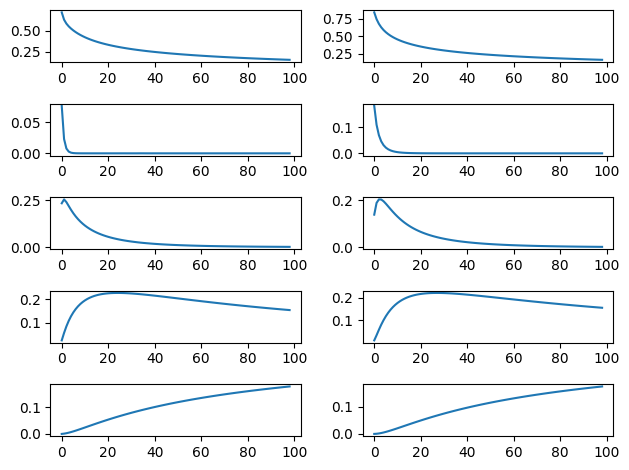

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 2)
# ax1.plot(rates)
# ax[0].plot(batch_loss)
for i in range(5):
  ax[i][0].plot(y.transpose(0,1)[i])
  # ax[i][1].plot(torch.cat(train_values).transpose(0,1)[i])
  ax[i][1].plot(torch.cat(inference_values).transpose(0,1)[i])
  plt.tight_layout()

### testing